In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

In [2]:
class ClassicalLSTMModel(nn.Module):
    """
    Builds a purely classical LSTM model for time-series classification.
    This serves as a baseline to compare against the hybrid quantum model.
    """
    def __init__(self, n_features, n_lstm_units=16):
        super(ClassicalLSTMModel, self).__init__()
        
        # 1. Standard LSTM Layer
        # This layer processes the full sequence efficiently.
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=1,
            batch_first=True, # This is important!
            dropout=0.2 # Add dropout for regularization
        )
        
        # 2. Feed-Forward Classifier
        # A simple linear layer to map the LSTM's output to a single prediction logit.
        self.classifier = nn.Linear(n_lstm_units, 1)

    def forward(self, x):
        # x has shape: (batch_size, seq_length, n_features)
        
        # 1. Pass data through the classical LSTM
        # We only need the final output, not the hidden states (h_n, c_n).
        # lstm_out has shape (batch_size, seq_length, n_lstm_units)
        lstm_out, _ = self.lstm(x)
        
        # 2. We are interested in the features from the very last timestep
        # final_lstm_output has shape (batch_size, n_lstm_units)
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Pass the final output through the classifier
        # output has shape (batch_size, 1)
        output = self.classifier(final_lstm_output)

        # 4. Apply sigmoid activation to get a probability
        return torch.sigmoid(output).squeeze()

In [3]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_2024_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_2024_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')
    
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    return df, feature_columns, le_location


In [4]:
def create_sequences_memory_efficient(df, feature_columns, sequence_length=168, stride=24):
    """Create sequences. Input: 7 days (168h), Output: class of the next hour"""
    print("Creating sequences...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()
    
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        
        # Stride over the data to create sequences
        for j in range(0, len(loc_df) - sequence_length, stride):
            X_seq = loc_X.iloc[j : j + sequence_length].values
            y_target = loc_y[j + sequence_length] # Target is the single class of the next hour
            
            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)
        
        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")
    
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)
    
    print(f"Total sequences: {X_sequences.shape[0]}")
    return X_sequences, y_sequences, location_indices, scaler

In [5]:
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model."""
    print("Starting training with PyTorch...")
    # Check for CUDA availability and set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0)
        
        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0)

        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_classical_lstm_model.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break
                
    model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
    return model, history

In [6]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('classical_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.
Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Using a subset of data for demonstration (first 20 locations)...
Creating sequences...
Total sequences: 7180
Training set shape: (5744, 168, 5)
Test set shape: (1436, 168, 5)

Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(5, 4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=4, out_features=1, bias=True)
)
Starting training with PyTorch...


/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50 - Loss: 0.6131, Acc: 0.6428 - Val Loss: 0.4258, Val Acc: 0.8997 - Duration: 0.48s
  -> Validation loss improved. Saving model.
Epoch 2/50 - Loss: 0.3636, Acc: 0.8877 - Val Loss: 0.3103, Val Acc: 0.9081 - Duration: 0.25s
  -> Validation loss improved. Saving model.
Epoch 3/50 - Loss: 0.2974, Acc: 0.9020 - Val Loss: 0.2611, Val Acc: 0.9164 - Duration: 0.24s
  -> Validation loss improved. Saving model.
Epoch 4/50 - Loss: 0.2557, Acc: 0.9096 - Val Loss: 0.2237, Val Acc: 0.9311 - Duration: 0.24s
  -> Validation loss improved. Saving model.
Epoch 5/50 - Loss: 0.2234, Acc: 0.9206 - Val Loss: 0.1961, Val Acc: 0.9415 - Duration: 0.24s
  -> Validation loss improved. Saving model.
Epoch 6/50 - Loss: 0.1975, Acc: 0.9314 - Val Loss: 0.1739, Val Acc: 0.9450 - Duration: 0.25s
  -> Validation loss improved. Saving model.
Epoch 7/50 - Loss: 0.1781, Acc: 0.9349 - Val Loss: 0.1577, Val Acc: 0.9499 - Duration: 0.23s
  -> Validation loss improved. Saving model.
Epoch 8/50 - Loss: 0.1631, Acc: 0.

/tmp/ipykernel_88248/518800599.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


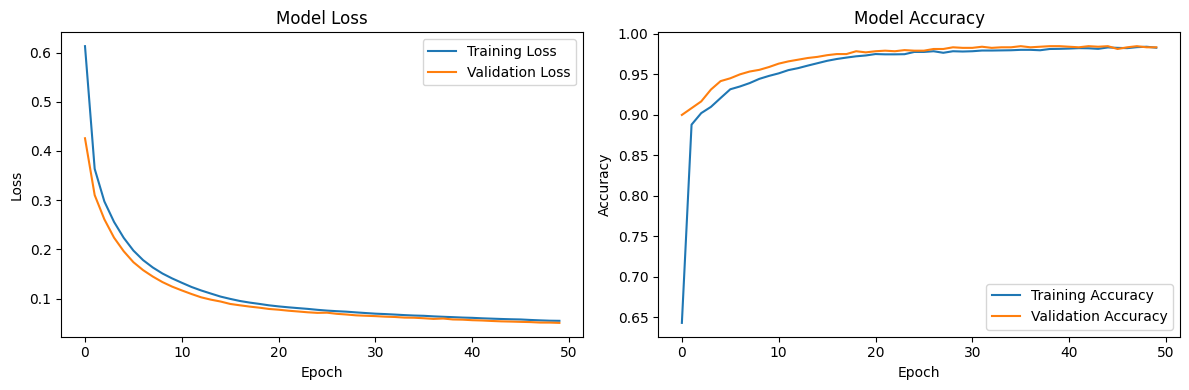


Classical LSTM training completed successfully!


In [7]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

try:
    df, feature_columns, le_location = load_and_prepare_data()
    
    print("Using a subset of data for demonstration (first 20 locations)...")
    unique_locs_subset = df['location_encoded'].unique()[:20]
    df_subset = df[df['location_encoded'].isin(unique_locs_subset)]

    X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
        df_subset, feature_columns, sequence_length=168, stride=24
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=location_indices
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    del X_sequences, y_sequences, location_indices, X_train, X_test, y_train, y_test
    gc.collect()

    model = ClassicalLSTMModel(n_features=len(feature_columns), n_lstm_units=4)
    print("\nClassical LSTM Model Architecture:")
    print(model)
    
    model, history = train_model_pytorch(model, train_loader, val_loader, epochs=50, patience=5)
    
    plot_training_history(history)
    
    
    print("\nClassical LSTM training completed successfully!")
    
except Exception as e:
    print(f"\nAn error occurred: {e}")
    import traceback
    traceback.print_exc()
